In [1]:
from taildropout import TailDropout
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Basics & properties : Comparison to regular dropout

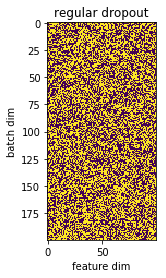

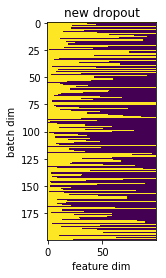

In [2]:
x = torch.ones(200,100)
y = nn.Dropout(0.5)(x)
plt.imshow(y);plt.ylabel('batch dim');plt.xlabel('feature dim')
plt.title('regular dropout')
plt.show()

y = TailDropout(0.5)(x)
plt.imshow(y);plt.ylabel('batch dim');plt.xlabel('feature dim')
plt.title('new dropout')
plt.show()

##### There's three modes:
* `.train()` (default)
* `.eval()`
* `deterministic` 

In [3]:
cdropout = TailDropout()
# Train
y = cdropout(x)
assert ~y.equal(x)

# Eval
cdropout.eval()
y = cdropout(x)
assert y.equal(x)

# Deterministic (keep first `dropout start` features)
y = cdropout(x,dropout_start = 10)
assert y[:,10:].sum()==0

You can choose which channel (`dropout_dim`) that should be sequentialy dropped out over, and witch dimension that should yield an individual random mask (`batch_dim`)

In [4]:
# TailDropout(p=0.5, batch_dim=0, dropout_dim = -1) # <- default
TailDropout(p=0.5, batch_dim=1, dropout_dim = 2)(torch.ones(3,2,10))>0

tensor([[[ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

        [[ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

        [[ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0]]], dtype=torch.uint8)

## Details: Distribution of amount of used nodes
To make it simple, the chosen `k` is set to follow a truncated exponential distribution, but this could be anything really.

* Compared to regular dropout; more often is all neurons used
* Compared to regular dropout all neurons have different dropout-probability
* The probability of very few neurons used is vanishing with regular dropout while existant (but small) with this type
* If neuron `j` is being open it implies that neuron `j-1` is open, so there's `K` subsets of nodes total (vs $2^K$ for regular dropout) with K the number of features.

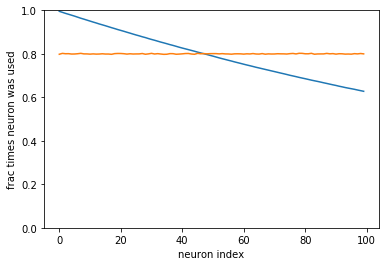

median  80.0 100.0
mean  80.00477 79.79147


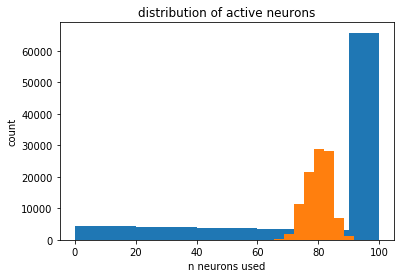

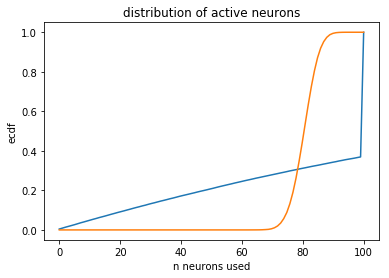

In [5]:
dropout = nn.Dropout(0.2)
cdropout = TailDropout(0.2)
n = 100000
n_features = 100
x = torch.ones([n,n_features])

y = (dropout(x)>0).float().float()
yc = cdropout(x)

plt.plot(yc.mean(0).numpy(),label='contiguous')
plt.plot(y.mean(0).numpy(),label='regular')
plt.ylim(0,1)
plt.ylabel('frac times neuron was used')
plt.xlabel('neuron index')
plt.show()

n_active,n_activec = y.sum(1).data.numpy(),yc.sum(1).data.numpy()
plt.hist(n_activec)
plt.hist(n_active)
print('median ',np.median(n_active),np.median(n_activec))
print('mean ',np.mean(n_active),np.mean(n_activec))
plt.xlabel('n neurons used')
plt.ylabel('count')
plt.title('distribution of active neurons')
plt.show()

from statsmodels.distributions.empirical_distribution import ECDF
p = np.linspace(0,1,100)

ecdf = ECDF(yc.mean(1))
plt.plot(p*n_features,ecdf(p))

ecdf = ECDF(y.mean(1))
plt.plot(p*n_features,ecdf(p))

plt.title('distribution of active neurons')
plt.ylabel('ecdf')
plt.xlabel('n neurons used')
plt.show()
